In [ ]:
# Prepare Data
#
import pandas as pd;

# This is an extensive data set and contain several other features. 
# This data set contains data about the batsman (both striker and non-striker) and bowler
data = pd.read_csv('../data_files/final_over_data_v2.csv');

# Use the match_id as the Key / Index column.
data.set_index("match_id", inplace = True)

# We have runs to win (numerical data). If the runs to win in last over are more than 36, the match is anyways lost.
# So, we'll convert it to Runs per bowl required. Anything above 36 will be considered as 7
# We'll bin it so that we dont have the continious data.
cut_labels = ['1','2','3','4','5','6', '7'];
cut_bins = [0, 6, 12, 18, 24, 30, 36, 200];

# Insert directly after runs to win column.
data.insert(3,'RPB',pd.cut(data['runs_to_win'], bins=cut_bins, labels=cut_labels))
data.head(10)

In [18]:
## Check for data quality.
#data["bowler_eg_economy"].isnull()

# For training, we take a subset of columns.
training_data = data[["RPB","wickets_in_hand","bowler_eg_economy","batsman_eg_sr","non_striker_eg_sr","match_result"]]
training_data.head()

# To check if there is any data with Null values.
#null_data = training_data[training_data.isnull().any(axis=1)]
#null_data.head(10)

,RPB,wickets_in_hand,bowler_eg_economy,batsman_eg_sr,non_striker_eg_sr,match_result
match_id,,,,,,
829774,4,4,10.5604,180.7692,146.0465,Won
392241,5,4,10.7230,109.0909,112.7907,Won
392201,2,6,10.4821,160.0000,109.0909,Lost
392234,2,4,9.5215,182.2469,112.7907,Won
829732,1,6,10.7230,157.3477,146.0465,Lost


In [19]:
# This is the simplest version of Analysis (my first version)
# We'll use a Decision Tree Classifier
#
# 
from sklearn import tree
from sklearn.model_selection import train_test_split
import graphviz

# Split the training data into Train and Test.
train_set, test_set = train_test_split(training_data, test_size=0.2)


# Training columns. For now, I'm taking only few columns.
X = train_set[["RPB","wickets_in_hand","bowler_eg_economy","batsman_eg_sr","non_striker_eg_sr"]]
y = train_set["match_result"]
#y=y.astype('int')

# For now, we'll create a default tree. We'll see the accuracy / complexity and then decide the parameters.
# Some things to be adjusted are max_leaf_nodes
#
clf = tree.DecisionTreeClassifier()
clf=clf.fit(X,y)


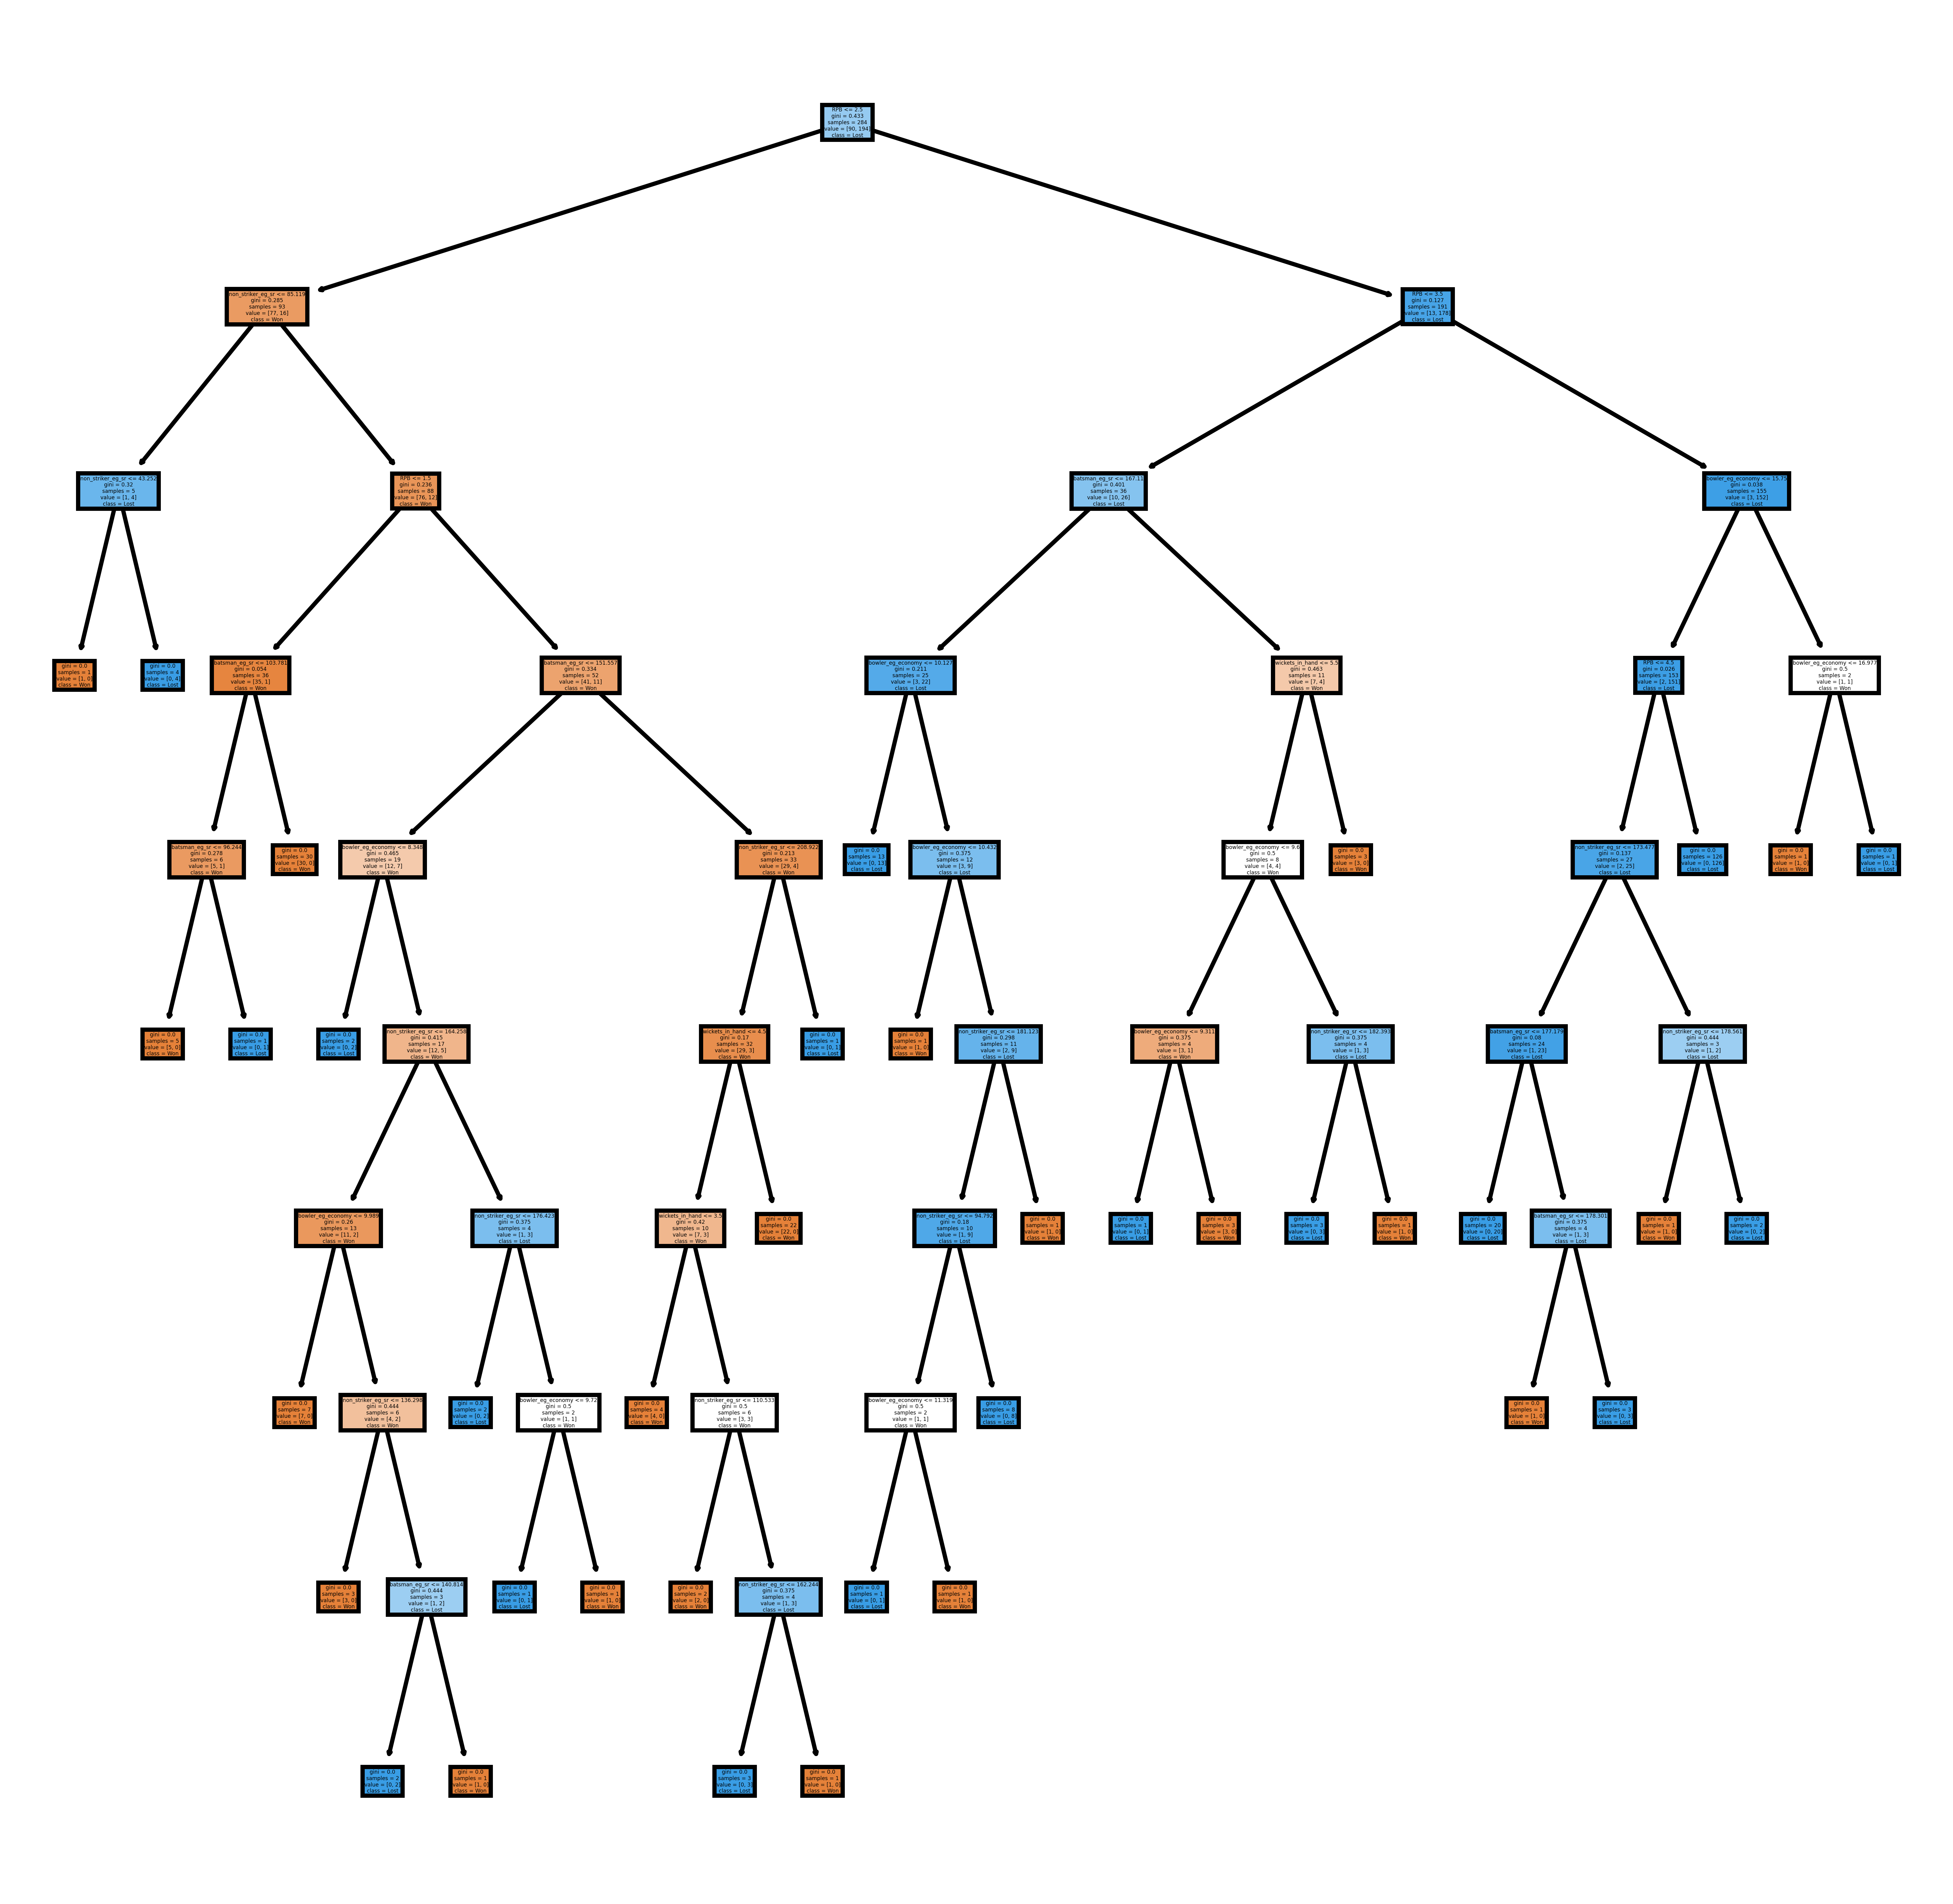

In [20]:
# Export the tree as a image.
import matplotlib.pyplot as plt

fn=["RPB","wickets_in_hand","bowler_eg_economy","batsman_eg_sr","non_striker_eg_sr"]
cn=['Won','Lost']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (8,8), dpi=1000)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('decision_tree.png')

In [21]:
# Test the Decision tree to calculate the accuracy
test_results = clf.predict(test_set[["RPB","wickets_in_hand","bowler_eg_economy","batsman_eg_sr","non_striker_eg_sr"]])

from sklearn.metrics import accuracy_score
accuracy_score(test_set["match_result"],test_results)


0.7916666666666666

In [ ]:
# Plot the confusion matrix to understand the prediction results.
from sklearn.metrics import plot_confusion_matrix
X_test = test_set[["RPB","wickets_in_hand","bowler_eg_economy","batsman_eg_sr","non_striker_eg_sr"]]
y_test = test_set["match_result"]
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

In [ ]:
# Analyze which matches were not predicted correctly.
#test_results
#tr = pd.DataFrame(test_results, columns=['act'])
#tr.insert(1,'predicted_result',test_set["match_result"])
#tr.head()
#act_vs_predicted = test_set["match_result"]
#act_vs_predicted['predicted_result'] = tr["act"]
#act_vs_predicted.insert(1,'predicted_result',tr["act"])
#pd.concat([act_vs_predicted, pd.DataFrame(test_results)], axis=1)
#act_vs_predicted.head()

In [ ]:
# Save model as a file
from joblib import dump
dump(clf, 'ml_model.joblib')

In [ ]:
# Load Model from file
from joblib import load
from sklearn.metrics import accuracy_score

mymodel = load('ml_model.joblib')

tdf = pd.DataFrame([{'innings_1_score': 170,'RPB': 2,'wickets_in_hand': 5,'bowler_econ': 9,'bowler_boundaries': 7,'batsman_sr': 125,'boundaries': 3}])
#tdf.head()
test_results = mymodel.predict(tdf)
test_results
#accuracy_score(test_set["match_result"],test_results)